<a href="https://colab.research.google.com/github/KevinRobledo123/Encript/blob/master/Robot_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Challenge 1: Robot Trading
Por: Kevin Robledo

## Paso 1: Confiuración del ambiente

In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt

In [2]:
#Versiones de las bibliotecas
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.11
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.22.4
------
Name: matplotlib
Version: 3.7.1


##Paso 2: Obtención de datos

In [3]:
#Importar las bibliotecas necesarias
import yfinance as yf
from bs4 import BeautifulSoup
import requests

###2.1. Precios históricos del bitcoin

La biblioteca yfinance es una herramienta de Python que permite descargar datos financieros de Yahoo Finance.

In [4]:
#Definimos la función importar_base_bitcoin() 
def importar_base_bitcoin():
  global df_bitcoin
  #Usando el método download para obtener el precio histórico de los últimos 7 días en intervalos de 5 min
  data = yf.Ticker("BTC-USD").history(period='7d', interval='5m')

  #Guardar los datos en un dataframe
  df_bitcoin = pd.DataFrame(data)

  return df_bitcoin

In [5]:
importar_base_bitcoin()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-05-15 00:00:00+00:00,26931.384766,26940.218750,26927.855469,26939.564453,0,0.0,0.0
2023-05-15 00:05:00+00:00,26942.525391,26942.525391,26920.029297,26920.029297,0,0.0,0.0
2023-05-15 00:10:00+00:00,26918.232422,26935.404297,26914.136719,26935.404297,0,0.0,0.0
2023-05-15 00:15:00+00:00,26919.871094,26919.871094,26811.279297,26812.771484,90236928,0.0,0.0
2023-05-15 00:20:00+00:00,26818.732422,26837.500000,26808.048828,26834.156250,38383616,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-21 05:20:00+00:00,27111.544922,27117.421875,27111.544922,27114.417969,20168704,0.0,0.0
2023-05-21 05:25:00+00:00,27111.822266,27115.585938,27110.251953,27115.585938,11272192,0.0,0.0
2023-05-21 05:30:00+00:00,27118.181641,27126.613281,27118.181641,27124.210938,16556544,0.0,0.0


### 2.2. Indicadores de tendencias

In [6]:
#Definimos la función extraer_tendencias()
def extraer_tendencias():
  global precio_actual,tendencia
  #Configuramos el scrapping
  url = 'https://coinmarketcap.com/'
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'lxml')

  #Obtener el precio actual
  precio_btc = soup.find('div', class_='sc-cadad039-0 clgqXO').get_text()
  #Guardar el precio en float en la variable precio_actual
  precio_btc = precio_btc.replace(',', '')
  precio_btc = precio_btc.replace('$', '')
  precio_actual = float(precio_btc)  

  #Obtener si la variación es positiva o negativa
  icon = soup.findAll('span', {'class':['sc-97d6d2ca-0 cYiHal','sc-97d6d2ca-0 bQjSqS']})[0]
  if 'sc-97d6d2ca-0 cYiHal' in ' '.join(icon['class']):
    tendencia = 'alta'
  else:
    tendencia = 'baja'

  #Obtener la variación en la última hora
  variacion = soup.find('span', class_='sc-97d6d2ca-0 cYiHal').get_text()

  return [precio_actual, tendencia, variacion]

In [7]:
extraer_tendencias()

[27121.8, 'baja', '0.94%']

##Paso 3: Limpieza de datos

In [8]:
import seaborn as sns
import numpy as np

In [9]:
#Definimos la función limpieza_datos()
def limpieza_datos():
  global media_bitcoin,df_bitcoin_limpio
  df = importar_base_bitcoin()
  #Creamos una copia para poder realizar la limpieza
  df_bitcoin_limpio = df.copy()

  #Eliminar los valores duplicados en el índice
  indices_unicos = df_bitcoin_limpio.index.drop_duplicates()
  df_bitcoin_limpio = df_bitcoin_limpio.reindex(indices_unicos)

  #Eliminar los valores nulos en la columna 'Close'
  df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True)

  #Mantener únicamente los registros que tengan un Volume > 0
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]

  #Eliminar outliers en el precio del Bitcoin
  close = df_bitcoin_limpio['Close']
  Q1 = close.quantile(.25)
  Q3 = close.quantile(.75)
  media = close.mean()
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ
  seleccion = ((close >= Q1) & (close < Q3))
  df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

  return [df_bitcoin_limpio, Q1, Q3, media]

In [10]:
limpieza_datos()

[                                   Open          High           Low  \
 Datetime                                                              
 2023-05-15 01:25:00+00:00  27014.630859  27078.990234  27010.048828   
 2023-05-15 01:30:00+00:00  27003.324219  27051.326172  27003.324219   
 2023-05-15 01:35:00+00:00  27070.365234  27170.148438  27070.365234   
 2023-05-15 01:40:00+00:00  27181.623047  27181.623047  27130.759766   
 2023-05-15 01:45:00+00:00  27142.683594  27162.771484  27125.705078   
 ...                                 ...           ...           ...   
 2023-05-21 05:20:00+00:00  27111.544922  27117.421875  27111.544922   
 2023-05-21 05:25:00+00:00  27111.822266  27115.585938  27110.251953   
 2023-05-21 05:30:00+00:00  27118.181641  27126.613281  27118.181641   
 2023-05-21 05:35:00+00:00  27124.658203  27125.666016  27121.228516   
 2023-05-21 05:40:00+00:00  27121.292969  27123.210938  27121.292969   
 
                                   Close     Volume  Dividends

In [11]:
#Creamos una función para mostrar el boxplot en pantalla
def boxplot():
  sns.set(style="whitegrid")
  boxplot = sns.boxplot(y='Close', data=df_bitcoin_limpio, color='#78A6C8', whis=2, width=0.25)
  plt.title('Distribución de precios de Bitcoin en dólares', fontsize=14)

  maximo = limpieza_datos()[2]
  media = limpieza_datos()[3]
  minimo = limpieza_datos()[1]

  #Ponemos guías para el valor máximo, mediana y mínimo
  boxplot.axhline(y=maximo, color='#D47751', linestyle='--') #Máximo
  boxplot.axhline(y=media, color='#E23E57', linestyle='--') #Mediana
  boxplot.axhline(y=minimo, color='#D47751', linestyle='--') #Mínimo

  #Texto que índica el valor del máximo, mediana y mínimo
  plt.text(x=0.25, y=limpieza_datos()[2], s=f'Máximo: {limpieza_datos()[2].round(1)}', fontsize=10, va='top', color='#E23E57')
  plt.text(x=0.25, y=media, s=f'Media: {media.round(1)}', fontsize=10, va='bottom', color='#E23E57')
  plt.text(x=0.25, y=limpieza_datos()[1], s=f'Mínimo: {limpieza_datos()[1].round(1)}', fontsize=10, va='bottom', color='#E23E57')

  return plt.show()

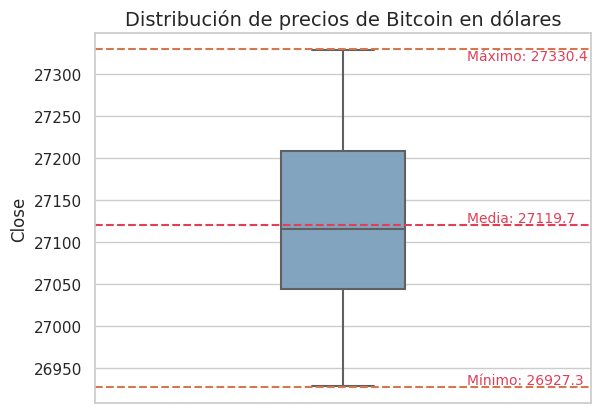

In [12]:
boxplot()

##Paso 4: Tomar decisiones

In [13]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, media_bitcoin, algoritmo_decision, df_bitcoin_limpio

  #Calculamos la media
  media_bitcoin = limpieza_datos()[3]

  #Determinamos los criterios
  if ((precio_actual >= media_bitcoin) & (tendencia == 'baja')):
    algoritmo_decision = 'Vender'
  elif ((precio_actual < media_bitcoin) & (tendencia == 'alta')):
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Esperar'
  
  return algoritmo_decision

In [14]:
tomar_decisiones()

'Vender'

##Paso 5: Visualización

In [15]:
import matplotlib.pyplot as plt

In [16]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_bitcoin_limpio
  #Adicionamos una nueva columna que almacena el valor media_bitcoin
  df_bitcoin['Promedio'] = media_bitcoin

  sns.set(style="whitegrid")
  #Configuramos el tamaño del gráfico
  plt.figure(figsize=(16,5))

  #Título del gráfico
  plt.title('¿Comprar, vender o esperar?', fontsize=14)

  #Dibujamos una línea en el gráfico con los datos del índice y de la columna 'Close'
  df_bitcoin['Close'].plot(legend = None, color = '#326789')

  ##Dibujamos una línea en el gráfico con los datos del índice y de la columna 'Promedio'
  df_bitcoin['Promedio'].plot(legend = None, ls='--', color = '#E65C4F')

  #Mostramos un mensaje con la decisión tomada
  plt.annotate(f'Decisión: {algoritmo_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(-180, -130), textcoords='offset points', fontsize=14)

  #Mostramos el gráfico en pantalla
  plt.show()


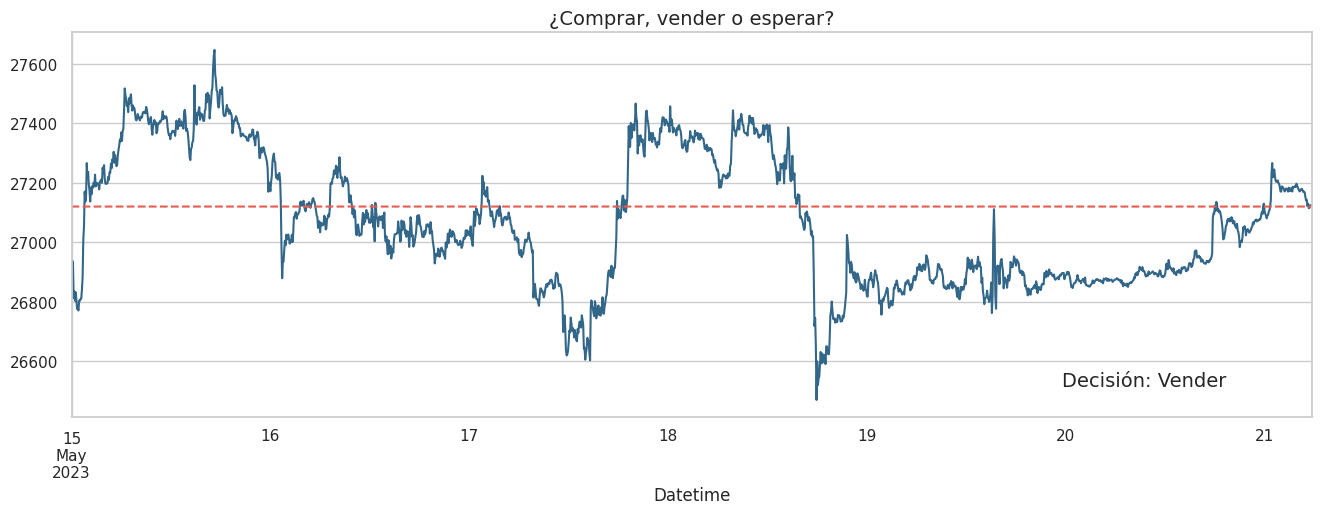

In [17]:
visualizacion()

##Paso 6: Automatización

In [18]:
from IPython.display import clear_output
import time

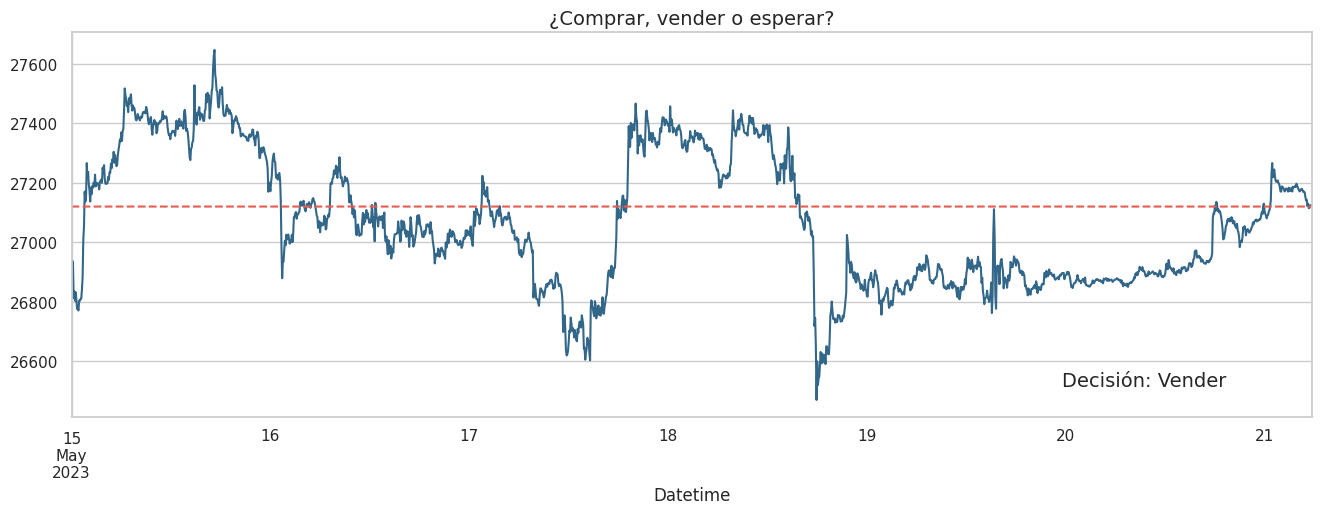

In [ ]:
#Construimos un loop infinito para ejecutar las funciones que hemos construido
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)